# <b><font color='blue'>Notebook para el cálculo de gamma-index 2D medida 

<b><font color='blue'>Importación de bibliotecas</font></b>

In [1]:
import wx

import pydicom
from pydicom.dataset import Dataset, FileDataset
import pydicom.uid

import SimpleITK as sitk

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.ndimage import filters
from scipy.optimize import curve_fit

%matplotlib inline
from ipywidgets import *
%run registration_utilities.py
from IPython.display import display
plt.style.use('ggplot')

<b><font color='blue'>Funciones auxiliares</font></b>

In [2]:
def get_path(wildcard):
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Open', wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

def point2index(my_point, film_extent, pixel_spacing):
    
    # fucking redondeo
    ind_x = np.int((my_point[0] - film_extent[0])/pixel_spacing)
    ind_y = np.int((my_point[1] - film_extent[3])/pixel_spacing)
    
    
    return np.array([ind_y, ind_x])

def get_array_extent(array_size, pixel_spacing, origin):
    # return extent : scalars (left, right, bottom, top) (en los bordes de la imagen, no en los centros de los píxeles)
    
    x_min = origin[0] - pixel_spacing/2.0
    x_max = array_size[1]*pixel_spacing - pixel_spacing/2.0 + origin[0]
    y_min = origin[1] - pixel_spacing/2.0
    y_max = array_size[0]*pixel_spacing - pixel_spacing/2.0 + origin[1]
                                                                                                         
    return np.array([x_min, x_max, y_max, y_min])

<b><font color='blue'>Funciones de visualización</font></b>

In [3]:
def display_array_with_colormap(my_array, array_extent, colormap, l_limit, u_limit):     
    
    plt.figure(figsize = (8, 8))

    plt.imshow(my_array, cmap = colormap, vmin=l_limit, vmax = u_limit, 
               interpolation = 'none', extent = array_extent)#
    plt.colorbar(fraction=0.1, pad=0.04)
    plt.show()
    
def display_arrays_with_alpha(plan_array, film_array, 
                              plan_extent, film_extent, 
                              alpha, 
                              plan_l_limit, plan_u_limit,
                              film_l_limit, film_u_limit):
       
    plt.figure(figsize = (6, 6))

    plt.imshow(film_array,  alpha = 1.0,cmap = 'Greens', vmin = film_l_limit, vmax = film_u_limit, 
               interpolation = 'none', extent = film_extent)

    plt.imshow(plan_array,alpha = alpha, cmap = 'gray', vmin = plan_l_limit, vmax = plan_u_limit, 
               interpolation = 'none', extent = plan_extent)
   
    plt.show()    
    
def display_arrays_with_alpha_profile(plan_array, film_array, 
                                array_extent, pixel_spacing, array_size,
                                norm, pdt, ref_dose,
                                alpha, 
                                plan_l_limit, plan_u_limit,
                                film_l_limit, film_u_limit,
                                y_pos):
   
    ind_y = np.int((y_pos - array_extent[3])/pixel_spacing)
    
    x = np.linspace(array_extent[0] + pixel_spacing/2.0, array_extent[1] - pixel_spacing/2.0, array_size[1])
    
    y_film = film_array[ind_y,:]
    
    y_plan = plan_array[ind_y,:]
    
    delta_dose = pdt*ref_dose
    
    if norm == True:
        my_aspect = 100
        y_lim = [-0.25,1.5]
    else:
        my_aspect = 0.5
        y_lim = [-50.0,300.0]
        
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,20))
    
    ax1.imshow(film_array,  alpha = 1.0,cmap = 'Greens', vmin = film_l_limit, vmax = film_u_limit, 
               interpolation = 'none', extent = array_extent)

    ax1.imshow(plan_array,alpha = alpha, cmap = 'gray', vmin = plan_l_limit, vmax = plan_u_limit, 
               interpolation = 'none', extent = array_extent)
    
    ax1.axhline(y = y_pos, xmin = array_extent[0], xmax=array_extent[1], linewidth=2, color = 'k')
   
      
    ax2.plot(x,y_film,'g')
    ax2.plot(x,y_plan,'b')
    ax2.plot(x,y_plan+delta_dose,'--b')
    ax2.plot(x,y_plan-delta_dose,'--b')
    ax2.set_aspect(aspect = my_aspect)#'equal';‘datalim’, adjustable = 'box',0.5, 100
    ax2.set_ylim(y_lim)
   
    plt.show()    



<b><font color='blue'>Funciones de calibración</font></b>

In [4]:
def func_protcolo_inv(x, a, b): 
    # aqui las x son nod y devuelve dosis
    return a*(1.0-np.exp(-1.0*x))/(np.exp(-1.0*x)-b)


def func_protcolo(x, a, b): 
    # aqui las x son dosis y devuelve nod
    return -np.log((a+b*x)/(a+x))

def func_poli3(x, a, b, c):
    # aqui las x son nod y devuelve dosis
    return a*x**3 + b*x**2 + c*x


def calibracion_1(film_array, nod_cal, dosis_cal):
    
    popt1, pcov1 = curve_fit(func_protcolo, dosis_cal, nod_cal)
    
    nod_adj = np.arange(nod_cal[0],nod_cal[-1],0.001)

    dosis_adj = popt1[0]*(1.0-np.exp(-1.0*nod_adj))/(np.exp(-1.0*nod_adj)-popt1[1])
    
    film_array_calibrated = popt1[0]*(1-np.exp(-film_array))/(np.exp(-film_array)-popt1[1])
    
    return film_array_calibrated, nod_adj, dosis_adj, popt1

def calibracion_2(film_array, nod_cal, dosis_cal):
    
    popt1, pcov1 = curve_fit(func_poli3, nod_cal, dosis_cal)
    
    nod_adj = np.arange(nod_cal[0],nod_cal[-1],0.001)

    dosis_adj = popt1[0]*nod_adj**3 + popt1[1]*nod_adj**2 + popt1[2]*nod_adj
    
    film_array_calibrated = popt1[0]*film_array**3 + popt1[1]*film_array**2 + popt1[2]*film_array
    
    return film_array_calibrated, nod_adj, dosis_adj, popt1

<b><font color='blue'>Función gamma-index</font></b>

In [5]:
def gamma_index_2D(array_1, array_2, pixel_spacing, ref_dose, dta, pdt, th):
    
    '''
    array_1: imagen de referencia
    array_2: imagen a evaluar
    
    '''
    # defino algunas variables generales de la funcion
    delta_dose = pdt*ref_dose # dose tolerance as 3% of reference dose

    TH = th*ref_dose # dosis umbral a partir de la cual se calcula

    search_radius_mm = 3*dta #realiza la busqueda de gamma en un radio tres veces mayor al dta
            
    # Tamaño de la imagen de referencua y la imagen a evaluar   
    [size_y, size_x] = array_1.shape
        
    # Inicializo la matriz donde guardaré el resultado
    gamma = np.zeros([size_y, size_x])
    #gamma.fill(np.nan)     
    
    ############################################
    #### Primer término: Diferecia espacial ####
    ############################################
    
    # Todo este computo se realiza sobre la imagen de referencia (imagen 1).
       
    search_radius_pix = int(round(search_radius_mm/pixel_spacing))
    
    print search_radius_pix 

    # Tamaño en pixeles de la region de busqueda sobre la que se va a buscar el valor de gamma.
    sub_region_size = 2*search_radius_pix+1

    # Creo un array de numpy donde voy a guardar las distancias (al cuadrado) de esta region de busqueda.
    distance_sub_region = np.zeros([sub_region_size,sub_region_size], np.float32);

    # Recorro el array y guardo las distancias. En numpy, el ind_y va con las filas y el ind_x va con las columnas 
    # (acá eso no importa pero hay que tenerlo en cuenta más adelante).
    # El pixel_spacing debe ser el de la imagen de referencia (imagen 1). 
    # Tecnicamente, deberia guardar la distancia proximal a los pixeles vecinos y no al centro de los mismos.
    
    for ind_y in range(sub_region_size):
        for ind_x in range(sub_region_size):
            
            distance_sub_region[ind_y, ind_x] = (pixel_spacing**2)*((ind_y-search_radius_pix)**2 + 
                                                                      (ind_x-search_radius_pix)**2);
        
    first_term = distance_sub_region/(dta**2)
    
    #############################################
    #### Segundo término: Diferecia en dosis ####
    #############################################
    

    # A priori puedo iterar sobre todos los de la imagen a evaluar (imagen 2). 
    # Debo preocuparme por el padding en la imagen de referencia (imagen 1).

    # Debo padear image_1_array con un valor muy grande (de forma que nunca sea seleccionado por el min() de gamma)
    array_1_padded = np.lib.pad(array_1, ((search_radius_pix, search_radius_pix), 
                                                      (search_radius_pix, search_radius_pix)),
                                                      'constant', 
                                                      constant_values= ((np.nan, np.nan), (np.nan, np.nan)))

    # Obtengo las coordenadas del pixel en la imagen a evaluar correspondiente a los indices sobre los que itero
    for ind_y in range(size_y):
        for ind_x in range(size_x):
        
            eval_value = array_2[ind_y, ind_x] 
            ref_value  = array_1[ind_y, ind_x] 
        
            if eval_value > TH and ref_value>0.0: #
            
                #debo hacer el calculo solo cuando todos los indices caigan dentro de la imagen padeada
                dose_sub_region = array_1_padded[ind_y: ind_y + 2*search_radius_pix + 1, 
                                        ind_x: ind_x + 2*search_radius_pix + 1] 

                second_term = (dose_sub_region - eval_value)**2/(delta_dose**2)
                
                gamma[ind_y, ind_x] = np.sqrt(np.nanmin(first_term + second_term))
            
            else:
            
                gamma[ind_y, ind_x] = np.nan
                  
    data = gamma[~np.isnan(gamma)]

    Gamma = float(data[data <= 1.0].size)/float(data.size)*100.0
    
    return gamma, Gamma

## <b><font color='blue'>Lectura de imagen irradiada</font></b>

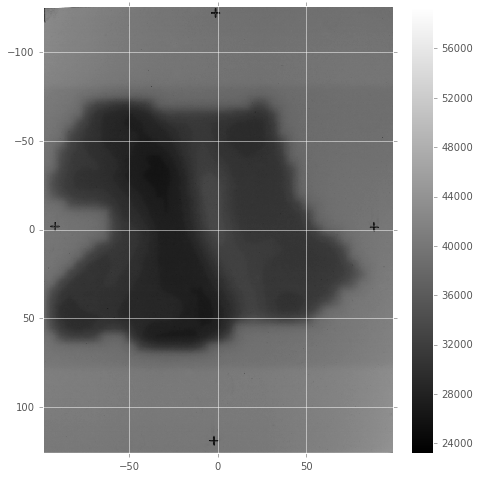

In [6]:
#----> Lectura del archivo <-----#
filename_film = get_path('*.tif')
filename_film = filename_film.encode('utf-8')

film_image_gray = sitk.ReadImage(filename_film, -1)


#----> Numpy <-----#
# Extracción del canal rojo y de la metadata
film_array = sitk.GetArrayFromImage(film_image_gray)

arrays_size = film_array.shape

arrays_pixel_spacing = np.float64(film_image_gray.GetSpacing()[0])

# Coordenadas x, y del pixel superior (o es inferior?!) izquierdo, de tal manera que el (0,0) quede en el centro de la imagen
arrays_origin = np.array([(1 - arrays_size[1])*arrays_pixel_spacing/2.0, (1 - arrays_size[0])*arrays_pixel_spacing/2.0])


arrays_extent = get_array_extent(arrays_size, arrays_pixel_spacing, arrays_origin)


[min_val_film, max_val_film] = np.float64([film_array.min(), film_array.max()])

print filename_film

# %matplotlib inline

interact(display_array_with_colormap , my_array = fixed(film_array), colormap = ['Greens','hot','gray'], 
         array_extent = fixed(arrays_extent),
         l_limit =(min_val_film, max_val_film,1.0), u_limit =(min_val_film, max_val_film,1.0));

## <b><font color='blue'>Lectura de imagen sin irradiar</font></b>

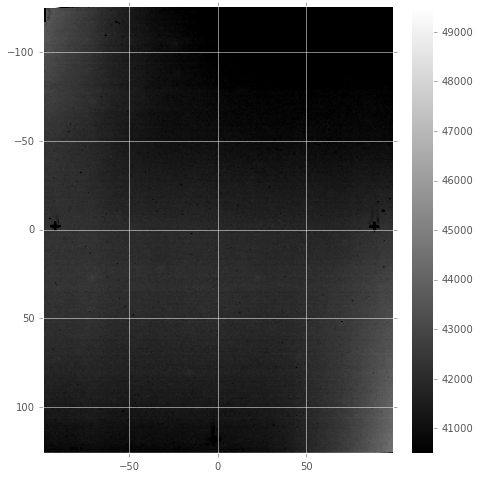

In [7]:
#----> Lectura del archivo <-----#
filename_film = get_path('*.tif')
filename_film = filename_film.encode('utf-8')

film_image_SI = sitk.ReadImage(filename_film, -1)

interpolator = sitk.sitkLinear
identity = sitk.Transform(2, sitk.sitkIdentity)
default_value = np.nan
reference_image = film_image_gray
image = film_image_SI
plan_image_resampled = sitk.Resample(image, reference_image, identity,
                          interpolator, default_value)
#----> Numpy <-----#
# Extracción del canal rojo y de la metadata
film_array_SI = sitk.GetArrayFromImage(plan_image_resampled)

[min_val_SI, max_val_SI] = np.float64([film_array_SI.min(), film_array_SI.max()])

%matplotlib inline

interact(display_array_with_colormap, my_array = fixed(film_array_SI ), 
         array_extent = fixed(arrays_extent), colormap = 'gray',
         l_limit =(min_val_SI, max_val_SI,1.0), u_limit =(min_val_SI, max_val_SI,1.0));

## <b><font color='blue'>Generacion de imagen en NOD</font></b>

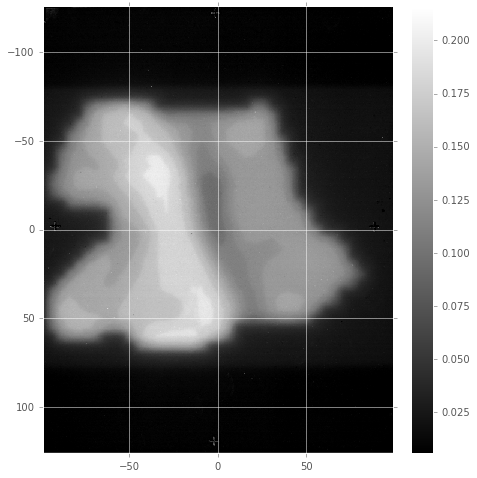

In [8]:
film_array_NOD = np.log10(np.float32(film_array_SI)/np.float32(film_array))
print film_array_NOD.dtype

[min_val_NOD, max_val_NOD] = np.float64([film_array_NOD.min(), film_array_NOD.max()])

%matplotlib inline

interact(display_array_with_colormap, my_array = fixed(film_array_NOD ), 
         array_extent = fixed(arrays_extent), colormap = 'gray',
         l_limit =(min_val_NOD, max_val_NOD,0.01), u_limit =(min_val_NOD, max_val_NOD,0.01));

<b><font color='blue'><b>Calibración de la imagen del film</font></b> 

F:\2016\proyecto films\Datos\Mendoza\calibration_data_Fuesmen_NOD.txt


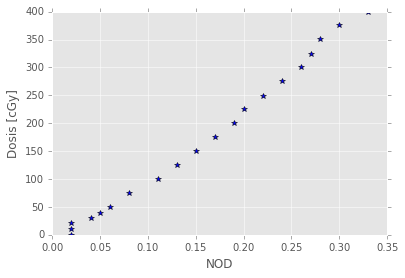

In [9]:
filename = get_path('*.txt')
    
dosis_cal, nod_cal = np.loadtxt(filename, skiprows = 1, unpack=True)

print filename

plt.figure()
plt.plot(nod_cal, dosis_cal,'*b')
plt.xlabel('NOD')
plt.ylabel('Dosis [cGy]')
plt.show()

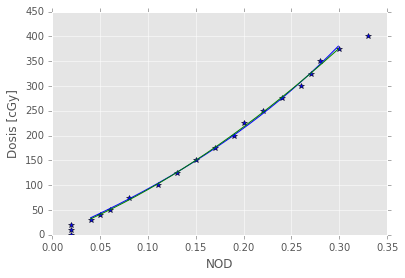

In [10]:
film_array_calibrated, nod_adj, dosis_adj, popt = calibracion_1(film_array_NOD, nod_cal[3:-1], dosis_cal[3:-1])

film_array_calibrated_2, nod_adj_2, dosis_adj_2, popt_2 = calibracion_2(film_array_NOD, nod_cal[3:-1], dosis_cal[3:-1])

plt.figure()
plt.plot(nod_cal, dosis_cal, '*b')
plt.plot(nod_adj, dosis_adj, 'b')
plt.plot(nod_adj_2, dosis_adj_2, 'g')
plt.xlabel('NOD')
plt.ylabel('Dosis [cGy]')
plt.ylim([0.0,450.0])
plt.show()

In [11]:
desvio_dosis = np.std(dosis_cal)
varianza_dosis = desvio_dosis*desvio_dosis

#valor de r**2 para calibracion 1

residuos_alcuadrado = np.square(dosis_cal - func_protcolo_inv(nod_cal, popt[0], popt[1]))
varianza_residual = np.sum(residuos_alcuadrado)/len(residuos_alcuadrado)

r_cuadrado = 1 - varianza_residual/varianza_dosis

print r_cuadrado

#valor de r**2 para calibracion 2

residuos_alcuadrado = np.square(dosis_cal - func_poli3(nod_cal, popt_2[0], popt_2[1], popt_2[2]))
varianza_residual = np.sum(residuos_alcuadrado)/len(residuos_alcuadrado)

r_cuadrado = 1 - varianza_residual/varianza_dosis

print r_cuadrado

0.991773137496
0.995623180807


<b><font color='blue'><b><b>Gráfico de la imagen del film</font></b> <font color='blue'>(opcional)</font>

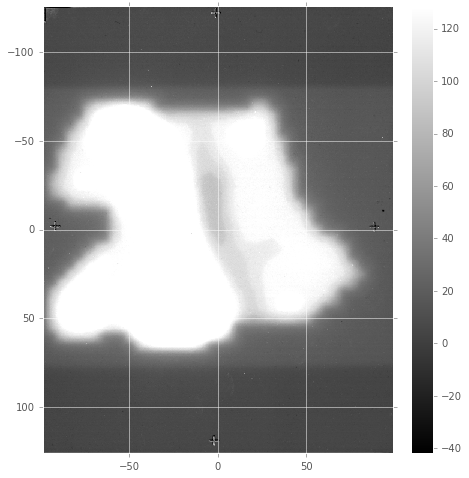

In [12]:
[min_val_cal, max_val_cal] = np.float64([film_array_calibrated.min(), film_array_calibrated.max()])

%matplotlib inline

interact(display_array_with_colormap, my_array = fixed(film_array_calibrated), 
         array_extent = fixed(arrays_extent), colormap = 'gray',
         l_limit =(min_val_cal, max_val_cal,0.01), u_limit =(min_val_cal, max_val_cal, 1.0));

## <b><font color='blue'>Procesamiento de la imagen planificada</font></b> 

In [14]:
# Load dicom 2D distribution (reference image)
# Pydicom automáticamente crea arrays de numpy

#----> Lectura del archivo <-----#
filename_dcm = get_path('*.dcm')

plan = pydicom.read_file(filename_dcm)

#----> Numpy <-----#

plan_array = np.float32(plan.pixel_array*plan.DoseGridScaling*100.0)

if arrays_size != plan_array.shape:
     
     raise Warning('No son del mismo tamanio')
    
if not np.isclose(arrays_pixel_spacing, np.array(plan.PixelSpacing)[0]): #se asume pixel cuadrado en el plan dicom
     
     raise Warning('No tienen el mismo tamanio de pixel')    


<b><font color='blue'><b>Gráfico de la imagen planificada</font></b> <font color='blue'>(opcional)</font>

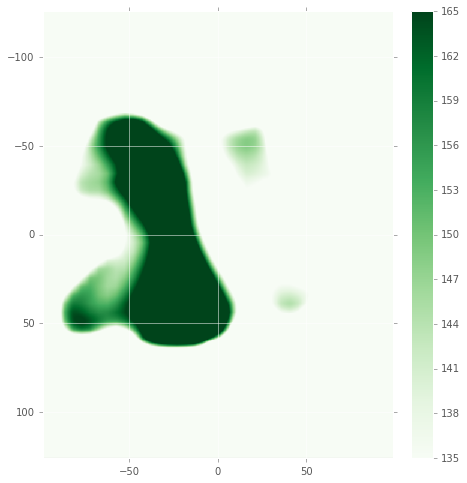

In [16]:
%matplotlib inline

interact(display_array_with_colormap, my_array = fixed(plan_array),
         array_extent = fixed(arrays_extent), colormap = ['Greens','hot','gray'],
         l_limit =(0.0,300.0,1.0), u_limit =(0.0,300.0,1.0));

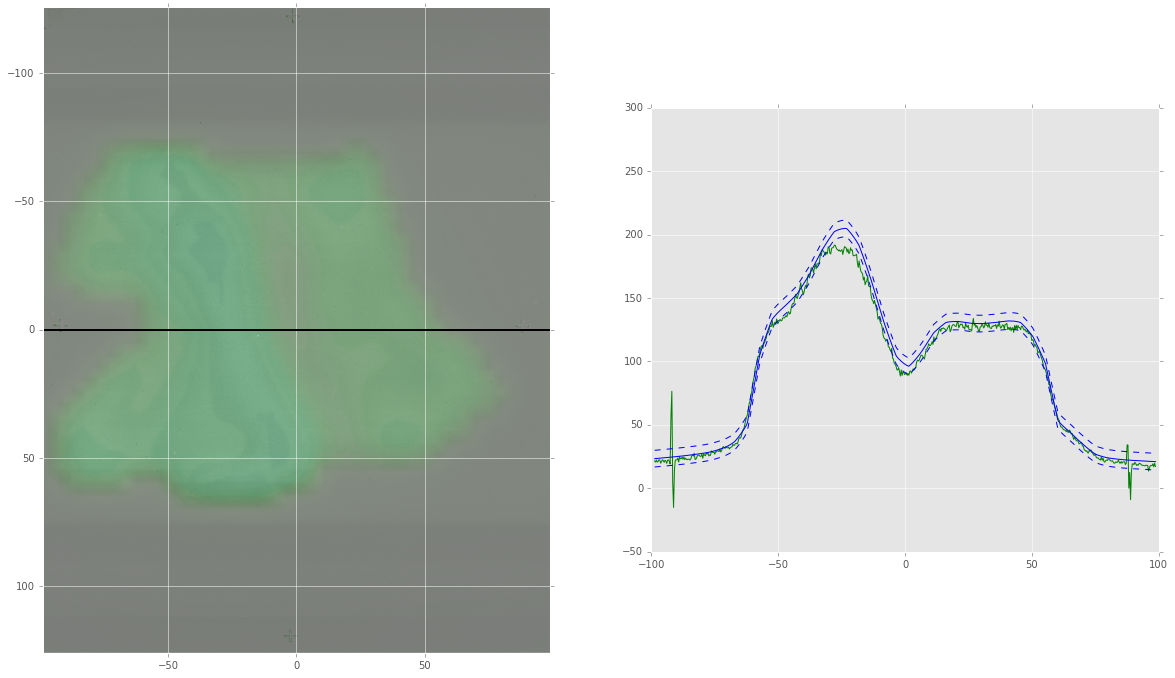

In [17]:
%matplotlib inline

interact(display_arrays_with_alpha_profile, plan_array = fixed(plan_array), film_array=fixed(film_array_calibrated), 
            array_extent = fixed(arrays_extent), pixel_spacing = fixed(arrays_pixel_spacing), array_size = fixed(arrays_size),
            norm = False, pdt = fixed(0.03), ref_dose = fixed(np.amax(plan_array)),
            alpha = (0.0,1.0,0.01), 
            plan_l_limit = (0.0,300.0,1.0),plan_u_limit = (0.0,300.0,1.0),
            film_l_limit = (0.0,300.0,1.0),film_u_limit = (0.0,300.0,1.0),
            y_pos = (arrays_extent[3],arrays_extent[2],1.0));

<b><font color='blue'><b>Suavizado</font></b> <font color='blue'>(opcional)</font>

In [ ]:
film_array_calibrated = filters.gaussian_filter(film_array_calibrated, 2.5, truncate=3.0)
#blurred = filters.gaussian_filter(a, sigma=7)

<b><font color='blue'><b>Normalización</font></b> <font color='blue'>(opcional)</font>

In [ ]:
# # Normalización manual a un punto
# norm_point = [10.0,0.0]
# norm_ind = point2index(norm_point, arrays_extent, arrays_pixel_spacing)

# Normalización al máximo del array de planificación
max_linear_index = np.argmax(plan_array)
norm_ind = np.unravel_index(max_linear_index, arrays_size)
print norm_ind


film_norm_val = film_array_calibrated[norm_ind[0], norm_ind[1]]

plan_norm_val = plan_array[norm_ind[0], norm_ind[1]]

print norm_ind
print plan_norm_val
print film_norm_val

film_array_norm = film_array_calibrated/film_norm_val
film_norm_val = film_array_norm[norm_ind[0],norm_ind[1]]
print film_norm_val

plan_array_norm = plan_array/plan_norm_val
plan_norm_val = plan_array_norm[norm_ind[0],norm_ind[1]]
print plan_norm_val

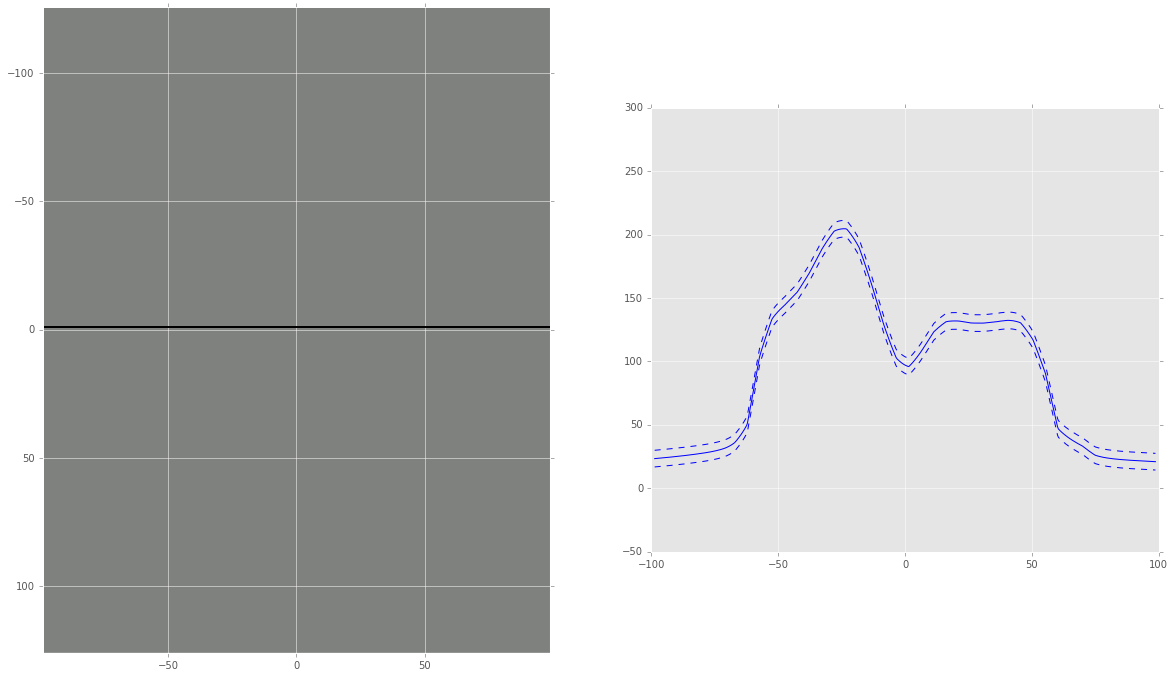

In [19]:
%matplotlib inline

interact(display_arrays_with_alpha_profile, plan_array = fixed(plan_array_norm), film_array=fixed(film_array_norm), 
         array_extent = fixed(arrays_extent), pixel_spacing = fixed(arrays_pixel_spacing), array_size = fixed(arrays_size),
         norm = False, pdt = fixed(0.03), ref_dose = fixed(np.amax(plan_array_norm)),
         alpha = (0.0,1.0,0.01), 
         plan_l_limit = (-0.25,1.5,0.01),plan_u_limit = (-0.25,1.5,0.01),
         film_l_limit = (-0.25,1.5,0.01),film_u_limit = (-0.25,1.5,0.01),
         y_pos = (arrays_extent[3],arrays_extent[2],1.0));

# <font color='blue'><b>Gamma-Index</font></b>

In [20]:
# lala = np.amax(plan_image)
# print lala
ref_dose = np.nanmax(plan_array) # 1.0 #plan_array.max() #200.0 #reference dose in cGy
dta = 3.0 # distance to agremment in mm
pdt = 0.04 # percet dose tolerance (percentage of the reference dose)
th = 0.1 # threshold (percentage of the reference dose)
print ref_dose
# print plan_image.GetSize()
# print plan_image.GetOrigin()
# print plan_image.GetSpacing()

# print film_image.GetSize()
# print film_image.GetOrigin()
# print film_image.GetSpacing()
#sitk.GetArrayFromImage(plan_image)[0,:,:].shape
gamma_array, Gamma = gamma_index_2D(plan_array, film_array_calibrated, arrays_pixel_spacing, ref_dose, dta, pdt, th)

219.074
27


In [21]:
print np.nanmax(gamma_array)
print np.nanmin(gamma_array)

print Gamma

12.8055810928
4.13554562328e-06
88.9215045237


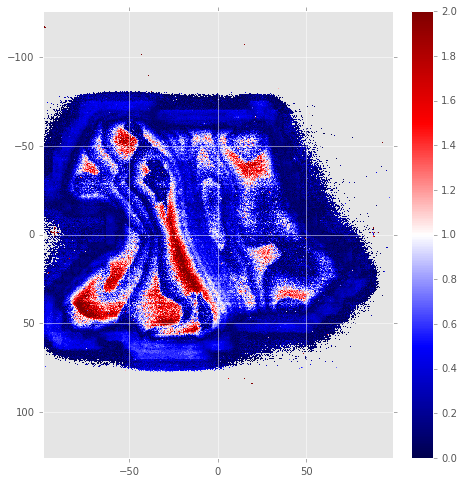

In [22]:
%matplotlib inline
plt.figure(figsize = (8, 8))

plt.imshow(gamma_array, cmap = 'seismic', vmin=0.0, vmax = 2.0, interpolation = 'none', extent = arrays_extent)
plt.colorbar(fraction=0.1, pad=0.04)
plt.show()